In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Parameters
look_back = 60
ticker = 'AAPL'

# Fetch data
data = yf.download(ticker, start='2015-01-01', end=datetime.now().strftime('%Y-%m-%d'))
print(data.head())
data = data[['Close']].dropna()

# Display dataset preview before preprocessing
print("\nDataset Preview:")
print(data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.320436  24.789806  23.879985  24.778683  212818400
2015-01-05  23.635286  24.169166  23.448429  24.089084  257142000
2015-01-06  23.637514  23.897780  23.274920  23.699800  263188400
2015-01-07  23.968960  24.069062  23.735387  23.846612  160423600
2015-01-08  24.889902  24.947740  24.180287  24.298187  237458000

Dataset Preview:
Price           Close
Ticker           AAPL
Date                 
2015-01-02  24.320436
2015-01-05  23.635286
2015-01-06  23.637514
2015-01-07  23.968960
2015-01-08  24.889902


In [3]:
# LSTM Preprocessing
scaler_lstm = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler_lstm.fit_transform(data)

# Create sequences
X_lstm, y_lstm = [], []
for i in range(len(data_scaled) - look_back):
    X_lstm.append(data_scaled[i:i+look_back, 0])
    y_lstm.append(data_scaled[i+look_back, 0])
X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

# Split data
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]
test_dates = data.index[train_size + look_back:]  # Adjust for look-back offset

# Reshape for LSTM
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], look_back, 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], look_back, 1)

# Build LSTM model
model_lstm = Sequential([
    LSTM(100, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM
early_stop_lstm = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_lstm = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=50, batch_size=32, callbacks=[early_stop_lstm], verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0160 - val_loss: 0.0015
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0011 - val_loss: 9.8216e-04
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.4625e-04 - val_loss: 0.0018
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.9257e-04 - val_loss: 0.0014
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5642e-04 - val_loss: 0.0026
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6055e-04 - val_loss: 0.0013
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1785e-04 - val_loss: 0.0011
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1095e-04 - val_loss: 8.4451e-04
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.1205e-04 - val_loss: 0.0024
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.5693e-04 - val_loss: 8.0138e-04
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.3340e-04 - val_loss: 8.7754e-04
Epoch 12/50

In [4]:
# LSTM Predictions
test_pred_lstm_scaled = model_lstm.predict(X_test_lstm)
test_pred_lstm = scaler_lstm.inverse_transform(test_pred_lstm_scaled)
y_test_lstm_inv = scaler_lstm.inverse_transform(y_test_lstm.reshape(-1, 1))

# LSTM Metrics
rmse_lstm = math.sqrt(mean_squared_error(y_test_lstm_inv, test_pred_lstm))
mae_lstm = mean_absolute_error(y_test_lstm_inv, test_pred_lstm)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [5]:
# CNN Preprocessing (same as LSTM)
scaler_cnn = MinMaxScaler(feature_range=(0, 1))
data_scaled_cnn = scaler_cnn.fit_transform(data)

# Create sequences
X_cnn, y_cnn = [], []
for i in range(len(data_scaled_cnn) - look_back):
    X_cnn.append(data_scaled_cnn[i:i+look_back, 0])
    y_cnn.append(data_scaled_cnn[i+look_back, 0])
X_cnn = np.array(X_cnn)
y_cnn = np.array(y_cnn)

# Split data
train_size_cnn = int(len(X_cnn) * 0.8)
X_train_cnn, X_test_cnn = X_cnn[:train_size_cnn], X_cnn[train_size_cnn:]
y_train_cnn, y_test_cnn = y_cnn[:train_size_cnn], y_cnn[train_size_cnn:]

# Reshape for CNN
X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], look_back, 1)
X_test_cnn = X_test_cnn.reshape(X_test_cnn.shape[0], look_back, 1)

# Build 1D CNN model
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(look_back, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model_cnn.compile(optimizer='adam', loss='mean_squared_error')

# Train CNN
early_stop_cnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_cnn = model_cnn.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=50, batch_size=32, callbacks=[early_stop_cnn], verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0150 - val_loss: 0.0046
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 0.0092
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 0.0089
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0066
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 0.0126
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0077

In [6]:
# CNN Predictions
test_pred_cnn_scaled = model_cnn.predict(X_test_cnn)
test_pred_cnn = scaler_cnn.inverse_transform(test_pred_cnn_scaled)
y_test_cnn_inv = scaler_cnn.inverse_transform(y_test_cnn.reshape(-1, 1))

# CNN Metrics
rmse_cnn = math.sqrt(mean_squared_error(y_test_cnn_inv, test_pred_cnn))
mae_cnn = mean_absolute_error(y_test_cnn_inv, test_pred_cnn)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [7]:
# Display combined metrics
print("\nModel Comparison - Metrics:")
metrics_data = pd.DataFrame({
    'Model': ['LSTM', '1D CNN'],
    'RMSE': [rmse_lstm, rmse_cnn],
    'MAE': [mae_lstm, mae_cnn]
})
print(metrics_data.to_string(index=False))


Model Comparison - Metrics:
 Model     RMSE      MAE
  LSTM 5.013839 3.552557
1D CNN 9.864007 7.792796


In [8]:
# Display sample of actual vs predicted data for both models
print("\nSample of Actual vs Predicted Prices:")
sample_size = min(10, len(y_test_lstm))
sample_data = pd.DataFrame({
    'Date': test_dates[-sample_size:],
    'Actual': y_test_lstm_inv[-sample_size:].flatten(),
    'LSTM_Predicted': test_pred_lstm[-sample_size:].flatten(),
    'CNN_Predicted': test_pred_cnn[-sample_size:].flatten()
})
print(sample_data.to_string(index=False))


Sample of Actual vs Predicted Prices:
      Date     Actual  LSTM_Predicted  CNN_Predicted
2025-03-31 222.130005      222.449585     217.906204
2025-04-01 223.190002      222.387863     217.421036
2025-04-02 223.889999      222.519363     216.490921
2025-04-03 203.190002      222.840958     216.636734
2025-04-04 188.380005      219.039398     216.198257
2025-04-07 181.460007      211.289520     215.779968
2025-04-08 172.419998      201.902206     215.727051
2025-04-09 198.850006      191.827209     215.591537
2025-04-10 190.419998      188.526367     215.316925
2025-04-11 198.149994      187.450043     213.589737


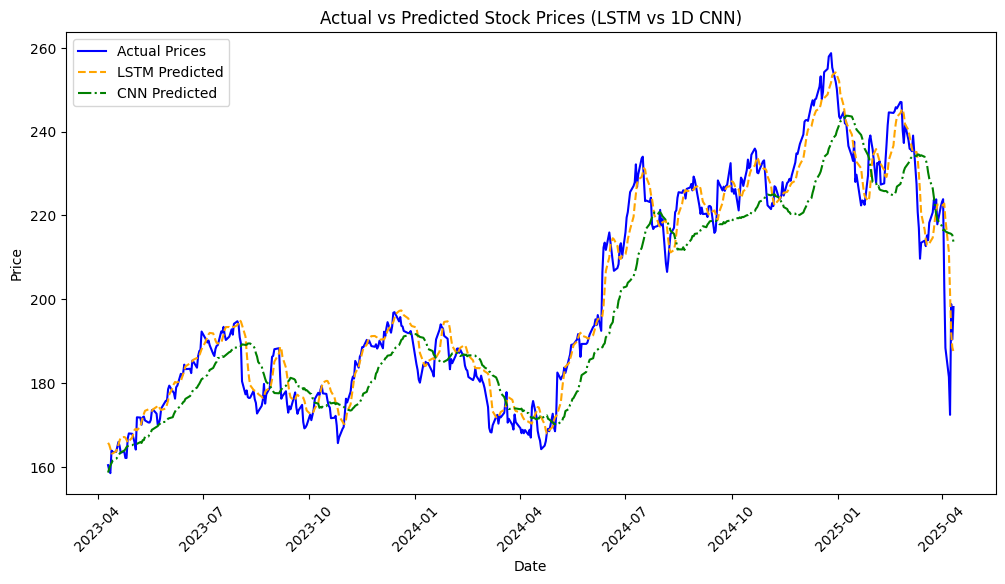

In [9]:
# Set up plot
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_lstm_inv, label='Actual Prices', color='blue')
plt.plot(test_dates, test_pred_lstm, label='LSTM Predicted', color='orange', linestyle='--')
plt.plot(test_dates, test_pred_cnn, label='CNN Predicted', color='green', linestyle='-.')
plt.title('Actual vs Predicted Stock Prices (LSTM vs 1D CNN)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
_ = plt.xticks(rotation=45)  # Suppress xticks output

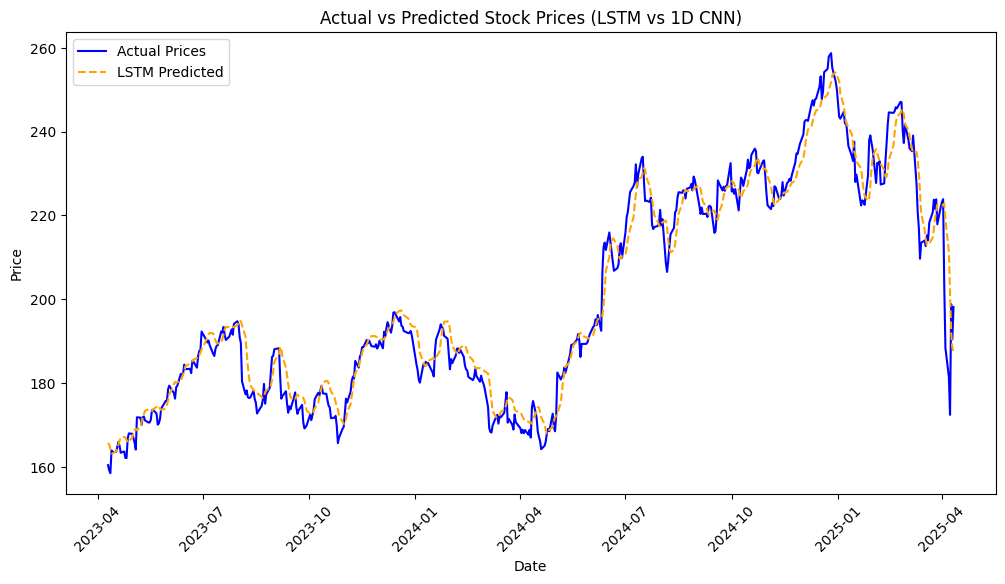

In [10]:
# Set up plot
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_lstm_inv, label='Actual Prices', color='blue')
plt.plot(test_dates, test_pred_lstm, label='LSTM Predicted', color='orange', linestyle='--')
#plt.plot(test_dates, test_pred_cnn, label='CNN Predicted', color='green', linestyle='-.')
plt.title('Actual vs Predicted Stock Prices (LSTM vs 1D CNN)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
_ = plt.xticks(rotation=45)  # Suppress xticks output

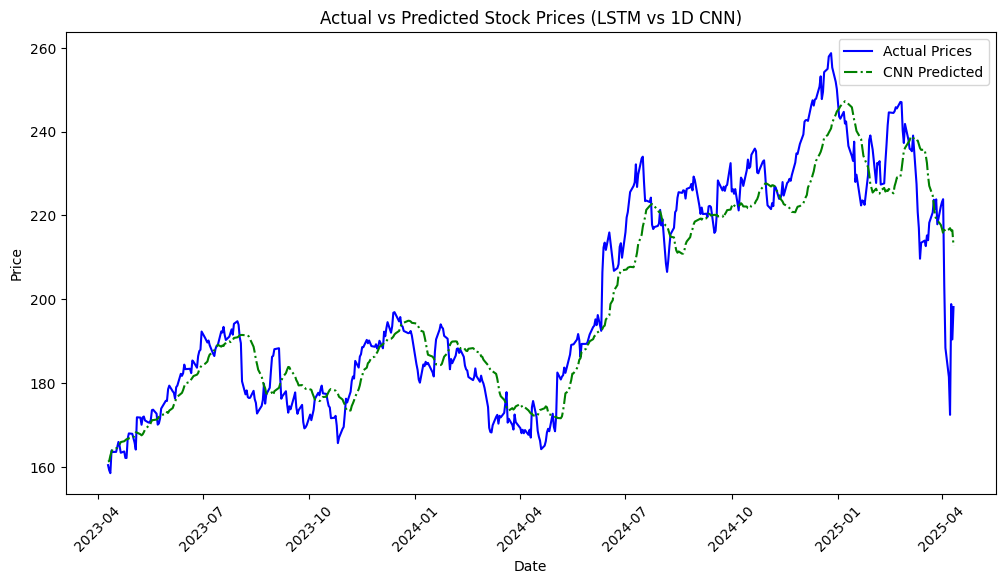

In [ ]:
# Set up plot
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_lstm_inv, label='Actual Prices', color='blue')
#plt.plot(test_dates, test_pred_lstm, label='LSTM Predicted', color='orange', linestyle='--')
plt.plot(test_dates, test_pred_cnn, label='CNN Predicted', color='green', linestyle='-.')
plt.title('Actual vs Predicted Stock Prices (LSTM vs 1D CNN)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
_ = plt.xticks(rotation=45)  # Suppress xticks output

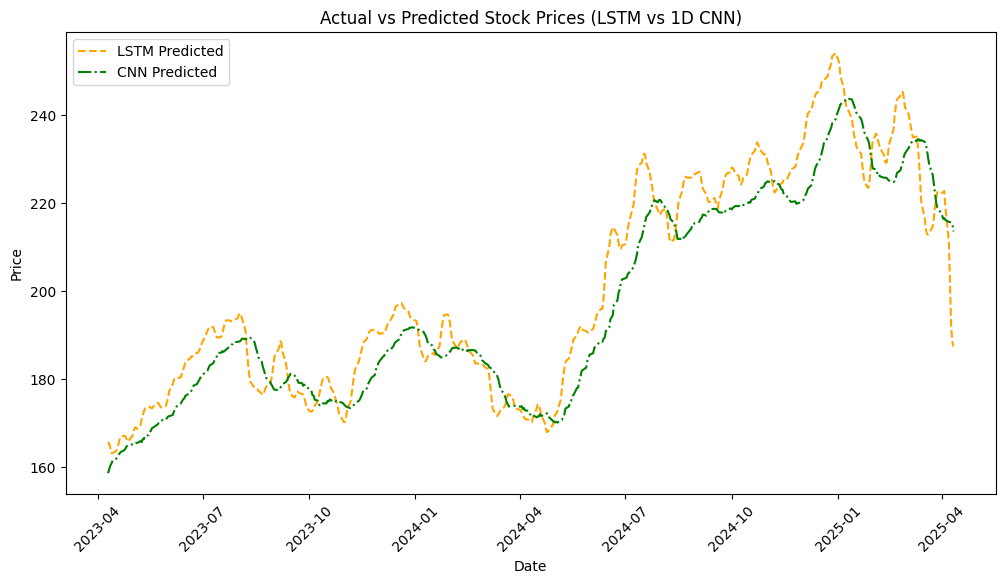

In [11]:
# Set up plot
plt.figure(figsize=(12, 6))
#plt.plot(test_dates, y_test_lstm_inv, label='Actual Prices', color='blue')
plt.plot(test_dates, test_pred_lstm, label='LSTM Predicted', color='orange', linestyle='--')
plt.plot(test_dates, test_pred_cnn, label='CNN Predicted', color='green', linestyle='-.')
plt.title('Actual vs Predicted Stock Prices (LSTM vs 1D CNN)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
_ = plt.xticks(rotation=45)  # Suppress xticks output

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, concatenate
from tensorflow.keras.optimizers import Adam

# ===== Set up training/testing data from LSTM-preprocessed arrays =====
X_train, y_train = X_train_lstm, y_train_lstm
X_test, y_test = X_test_lstm, y_test_lstm

# ===== Define Ensemble Model =====
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN branch
cnn_branch = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
cnn_branch = MaxPooling1D(pool_size=2)(cnn_branch)
cnn_branch = Dropout(0.2)(cnn_branch)
cnn_branch = Flatten()(cnn_branch)

# LSTM branch
lstm_branch = LSTM(128)(input_layer)

# Merge both branches
merged = concatenate([cnn_branch, lstm_branch])
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.2)(merged)
output = Dense(1)(merged)

ensemble_model_v2 = Model(inputs=input_layer, outputs=output)
ensemble_model_v2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train
history_ensemble_v2 = ensemble_model_v2.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0169 - val_loss: 0.0026
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 0.0094
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - val_loss: 9.9085e-04
Epoch 9/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 10/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0014 - val_loss: 9.6121e-04
Epoch 11/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 12/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0

In [23]:
# ===== Convert Scaled Prediction to Actual Price =====

import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, concatenate
from tensorflow.keras.optimizers import Adam


# ===== Set up training/testing data from LSTM-preprocessed arrays =====
# Assuming X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm are defined in previous cells
X_train, y_train = X_train_lstm, y_train_lstm
X_test, y_test = X_test_lstm, y_test_lstm

# ===== Define Ensemble Model (if not already defined) =====
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
# ... (rest of the ensemble model definition) ...

# Train (if not already trained)
# history_ensemble_v2 = ensemble_model_v2.fit(...)

# ===== Next Day Prediction with Improved Ensemble Model =====
# Assuming X_test_lstm is intended for prediction as it contains the test data
X_input = X_test_lstm[-1:]  # Last sequence
# In the original code, this line used 'X', which was not defined.
# Changed to 'X_test_lstm' to use the available test data.



# Assuming 'scaler_lstm' was intended for scaling 'y' as well
scaler_y = scaler_lstm  # Assign scaler_lstm to scaler_y

# Inverse transform the prediction to get actual price
real_price = scaler_y.inverse_transform(np.array(next_day_prediction_v2).reshape(-1, 1))
print("Predicted Next Day Price:", real_price[0][0])

Predicted Next Day Price: 192.94713


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


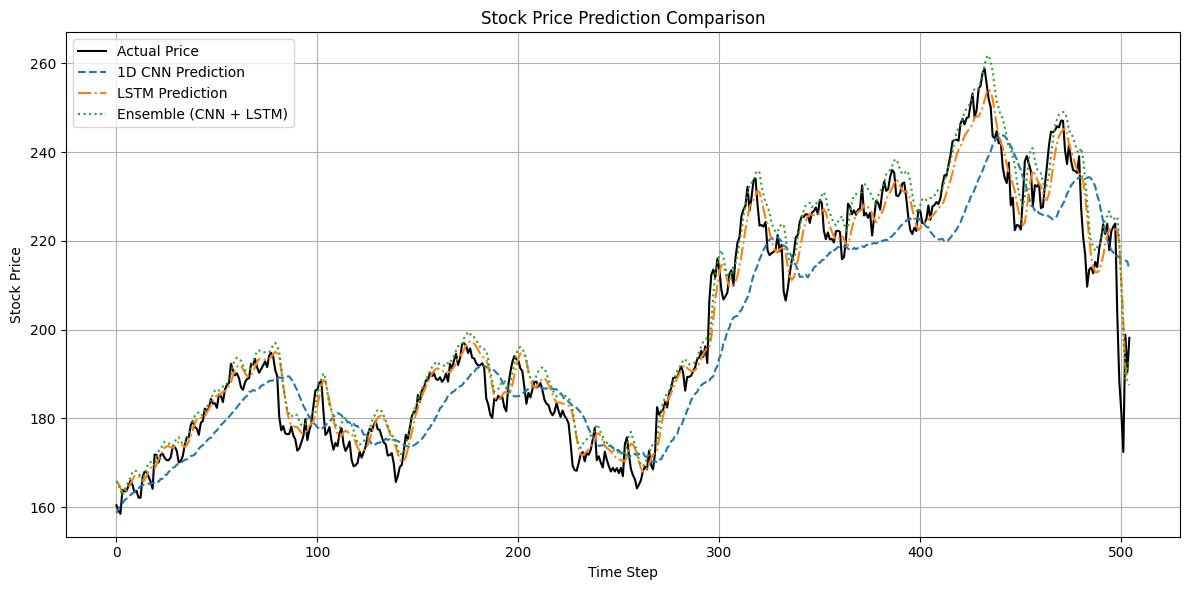

In [25]:
import matplotlib.pyplot as plt

# Get predictions from the trained models
cnn_predictions = model_cnn.predict(X_test_cnn)  # Get CNN predictions
lstm_predictions = model_lstm.predict(X_test_lstm)  # Get LSTM predictions
ensemble_v2_predictions = ensemble_model_v2.predict(X_test_lstm)  # Get Ensemble predictions


# Inverse transform predictions and actual values
actual_prices = scaler_y.inverse_transform(y_test.reshape(-1, 1))
cnn_prices = scaler_y.inverse_transform(cnn_predictions.reshape(-1, 1))
lstm_prices = scaler_y.inverse_transform(lstm_predictions.reshape(-1, 1))
ensemble_prices = scaler_y.inverse_transform(ensemble_v2_predictions.reshape(-1, 1))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price', color='black')
plt.plot(cnn_prices, label='1D CNN Prediction', linestyle='--')
plt.plot(lstm_prices, label='LSTM Prediction', linestyle='-.')
plt.plot(ensemble_prices, label='Ensemble (CNN + LSTM)', linestyle=':')
plt.title('Stock Price Prediction Comparison')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()